## 1. Preparación y visualización de los datos

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
plt.style.use("default")
import seaborn as sns
import folium

import warnings
warnings.filterwarnings("ignore")

In [2]:
df_raw = pd.read_csv("reviews_summary.csv",
                     true_values=['t'], false_values=['f'], na_values=[None, 'none'], parse_dates = ["date"])
df_raw.head(2)

,listing_id,date
0,6369,2010-03-14
1,6369,2010-03-23


In [3]:
df_raw["review_count"] = 1

In [4]:
print("El dataset tiene {} filas y {} columnas.".format(*df_raw.shape))
print("Tiene {} filas duplicadas.".format(df_raw.duplicated().sum()))

df_raw.head(2)

El dataset tiene 830895 filas y 3 columnas.
Tiene 1953 filas duplicadas.


,listing_id,date,review_count
0,6369,2010-03-14,1
1,6369,2010-03-23,1


In [5]:
df_raw.drop_duplicates(inplace=True)
print("Tiene {} filas duplicadas.".format(df_raw.duplicated().sum()))

Tiene 0 filas duplicadas.


## 2. Preprocesado de los datos

### 2.1. Manipulación de las opiniones el mes

In [6]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 828942 entries, 0 to 830894
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   listing_id    828942 non-null  int64         
 1   date          828942 non-null  datetime64[ns]
 2   review_count  828942 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 25.3 MB


In [7]:
df_raw.date = pd.to_datetime(df_raw.date, format = "%Y-%m-%d")

In [8]:
df_raw

,listing_id,date,review_count
0,6369,2010-03-14,1
1,6369,2010-03-23,1
2,6369,2010-04-10,1
3,6369,2010-04-21,1
4,6369,2010-04-26,1
...,...,...,...
830890,42264109,2020-02-17,1
830891,42264109,2020-02-18,1
830892,42269935,2020-02-16,1
830893,42271124,2020-02-16,1


In [9]:
ids = df_raw["listing_id"].unique()
months = []
for i in ids:
    inter = df_raw[df_raw["listing_id"] == i]
    months.append((inter["date"].iloc[-1] - inter["date"].iloc[0]).days/30)
months = pd.DataFrame(months).replace(0,4).values

In [10]:
df_raw = df_raw.groupby(["listing_id"]).sum()
df_raw["months"] = months

In [11]:
df_raw["reviews_per_month"] = df_raw["review_count"]/df_raw["months"]

In [12]:
df_raw = df_raw["reviews_per_month"].reset_index()

In [13]:
df_raw.head(2)
df_raw.duplicated().sum()

0

### 2.2. Juntar los Dataset

In [14]:
df_2 = pd.read_csv("/home/ignareyesa/Escritorio/TFG/Python/Madrid/listings.csv",
                   true_values=['t'], false_values=['f'], na_values=[None, 'none'])
df_2.shape

(21845, 106)

In [15]:
# La columan de "id" la vamos a usar para poder usar la funcion .merge, luego la eliminaremos
df = pd.merge(df_raw, df_2[["id", "price", "cleaning_fee", "neighbourhood_group_cleansed", "latitude", "longitude", "property_type", "room_type", "accommodates",
                            "bathrooms", "bedrooms", "bed_type", "host_is_superhost", "cancellation_policy","minimum_nights","availability_365", "availability_30",
                            "availability_90", "host_acceptance_rate", "review_scores_rating", "host_response_time", "instant_bookable", "amenities","is_location_exact" ]], 
              left_on="listing_id", right_on="id")
df.drop("id", axis = 1, inplace = True)
df.rename({'neighbourhood_group_cleansed':'neighbourhood'}, axis=1, inplace=True)

print("La base de datos tiene {} filas y {} columnas.".format(*df.shape))
print("Además, contiene {} filas duplicadas.".format(df.duplicated().sum()))
df.head(2)

La base de datos tiene 17368 filas y 25 columnas.
Además, contiene 0 filas duplicadas.


,listing_id,reviews_per_month,price,cleaning_fee,neighbourhood,latitude,longitude,property_type,room_type,accommodates,...,minimum_nights,availability_365,availability_30,availability_90,host_acceptance_rate,review_scores_rating,host_response_time,instant_bookable,amenities,is_location_exact
0,6369,0.607490,$70.00,$5.00,Chamartín,40.45724,-3.67688,Apartment,Private room,2,...,1,77,17,77,70%,98.0,within a few hours,False,"{Wifi,""Air conditioning"",Kitchen,Elevator,Heat...",True
1,21853,0.720524,$17.00,NaN,Latina,40.40341,-3.74084,Apartment,Private room,1,...,4,200,0,0,NaN,92.0,NaN,False,"{TV,Internet,Wifi,""Air conditioning"",Kitchen,""...",False


In [16]:
df.dtypes

listing_id                int64
reviews_per_month       float64
price                    object
cleaning_fee             object
neighbourhood            object
latitude                float64
longitude               float64
property_type            object
room_type                object
accommodates              int64
bathrooms               float64
bedrooms                float64
bed_type                 object
host_is_superhost        object
cancellation_policy      object
minimum_nights            int64
availability_365          int64
availability_30           int64
availability_90           int64
host_acceptance_rate     object
review_scores_rating    float64
host_response_time       object
instant_bookable           bool
amenities                object
is_location_exact          bool
dtype: object

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17368 entries, 0 to 17367
Data columns (total 25 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   listing_id            17368 non-null  int64  
 1   reviews_per_month     17368 non-null  float64
 2   price                 17368 non-null  object 
 3   cleaning_fee          14343 non-null  object 
 4   neighbourhood         17368 non-null  object 
 5   latitude              17368 non-null  float64
 6   longitude             17368 non-null  float64
 7   property_type         17368 non-null  object 
 8   room_type             17368 non-null  object 
 9   accommodates          17368 non-null  int64  
 10  bathrooms             17362 non-null  float64
 11  bedrooms              17361 non-null  float64
 12  bed_type              17368 non-null  object 
 13  host_is_superhost     17365 non-null  object 
 14  cancellation_policy   17368 non-null  object 
 15  minimum_nights     

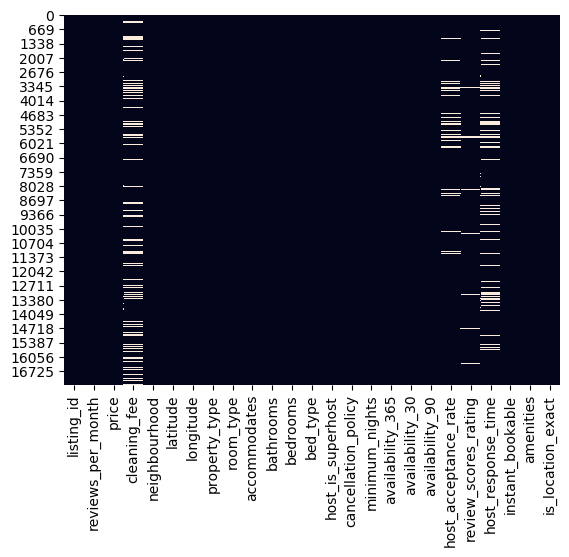

In [18]:
sns.heatmap(df.isnull(), cbar=False)

### 2.3. Limpieza de la columna de precios

Podemos observar que tanto la columna "price" como la columna "cleaning_fee" son del tipo "object", cuando deberián ser "float".
De "cleaning_fee" también hay varios valores nulos, seguuramente esto se deba a que la "cleaning_fee" sea 0.

In [19]:
df["price"] = df["price"].str.replace("$", "").str.replace(",","").astype("float")
df["price"].isnull().sum()

0

In [20]:
df["host_acceptance_rate"] = df["host_acceptance_rate"].str.replace("%","").astype("float")
df["host_acceptance_rate"].fillna(df["host_acceptance_rate"].mean())

0         70.000000
1         89.853669
2         73.000000
3        100.000000
4        100.000000
            ...    
17363    100.000000
17364     91.000000
17365    100.000000
17366    100.000000
17367    100.000000
Name: host_acceptance_rate, Length: 17368, dtype: float64

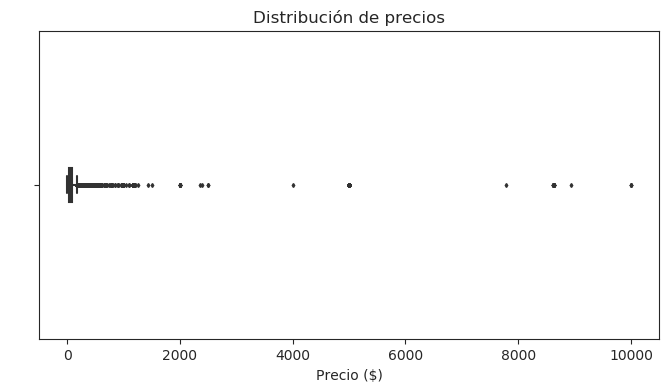

In [21]:
sns.set_style('ticks')
fig, ax = plt.subplots()

fig.set_size_inches(8, 4)
sns.boxplot(data = df, x ="price", orient="h", width=0.11, fliersize = 2, palette = ['#00A699'])
ax.set_title("Distribución de precios")
plt.ylabel(" ")
plt.xlabel("Precio ($)")
plt.show()

fig.savefig("/home/ignareyesa/Escritorio/TFG/Latex/Images/precios.png")

In [22]:
df = df[df.price < 301]
df["price"].describe()

count    16818.000000
mean        72.476513
std         49.830177
min          8.000000
25%         38.000000
50%         60.000000
75%         90.000000
max        300.000000
Name: price, dtype: float64

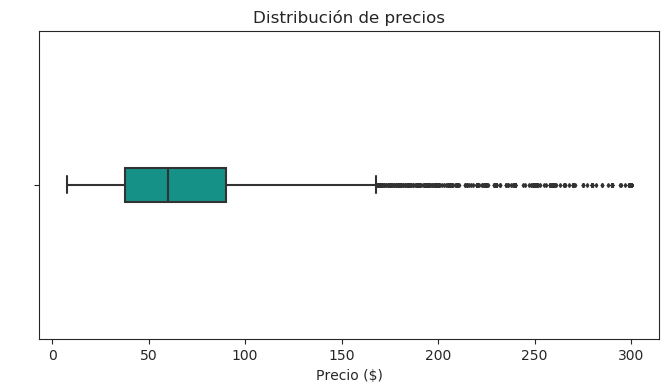

In [23]:
sns.set_style('ticks')
fig, ax = plt.subplots()

fig.set_size_inches(8, 4)
sns.boxplot(data = df, x ="price", orient="h", width=0.11, fliersize = 2, palette = ['#00A699'])
ax.set_title("Distribución de precios")
plt.ylabel(" ")
plt.xlabel("Precio ($)")
plt.show()

fig.savefig("/home/ignareyesa/Escritorio/TFG/Latex/Images/precios300.png")

In [24]:
df["cleaning_fee"] = df["cleaning_fee"].str.replace("$","").str.replace(",","").fillna("0").astype("float")
df["cleaning_fee"].isnull().sum()

0

In [25]:
df_esti1 = df.copy()
df_esti2 = df.copy()

### 2.4. Estimación de la ocupación

#### 2.4.1. Estimación modesta

In [26]:
estancia_media = 4.2
estimacion_modesta = 0.7
dias_mes = 30.5

In [27]:
df_esti1["modest_occupacy"] = estancia_media * df["reviews_per_month"] / (estimacion_modesta * dias_mes)
df_esti1 = df_esti1[df_esti1["modest_occupacy"] < 1.7]

## Normalizamos los datos
df_esti1["modest_occupacy"] = (df_esti1["modest_occupacy"]-df_esti1["modest_occupacy"].min())/(df_esti1["modest_occupacy"].max()-df_esti1["modest_occupacy"].min())*100
df_esti1.head(2)

,listing_id,reviews_per_month,price,cleaning_fee,neighbourhood,latitude,longitude,property_type,room_type,accommodates,...,availability_365,availability_30,availability_90,host_acceptance_rate,review_scores_rating,host_response_time,instant_bookable,amenities,is_location_exact,modest_occupacy
0,6369,0.607490,70.0,5.0,Chamartín,40.45724,-3.67688,Apartment,Private room,2,...,77,17,77,70.0,98.0,within a few hours,False,"{Wifi,""Air conditioning"",Kitchen,Elevator,Heat...",True,6.597713
1,21853,0.720524,17.0,0.0,Latina,40.40341,-3.74084,Apartment,Private room,1,...,200,0,0,NaN,92.0,NaN,False,"{TV,Internet,Wifi,""Air conditioning"",Kitchen,""...",False,7.914410


In [28]:
df_esti1.shape

(16385, 26)

In [29]:
df_esti1["modest_occupacy"].describe()

count    16385.000000
mean        27.100022
std         22.826652
min          0.000000
25%          7.463540
50%         22.067034
75%         40.938657
max        100.000000
Name: modest_occupacy, dtype: float64

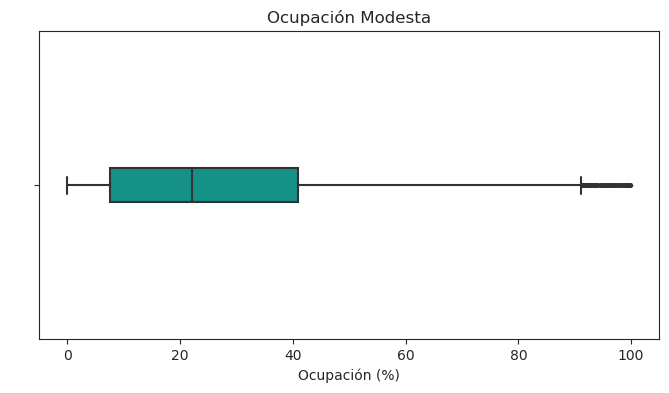

In [30]:
fig, ax = plt.subplots()
fig.set_size_inches(8, 4)


sns.boxplot(data = df_esti1, x ="modest_occupacy", orient="h", width=0.11, fliersize = 2, palette = ['#00A699'])
ax.set_title("Ocupación Modesta")
plt.ylabel(" ")
plt.xlabel("Ocupación (%)")
plt.show()

fig.savefig("/home/ignareyesa/Escritorio/TFG/Latex/Images/ocupamodesta.png")

In [31]:
x_max = np.percentile(df_esti1["modest_occupacy"], 75) + 1.5 * (np.percentile(df_esti1["modest_occupacy"], 75)- np.percentile(df_esti1["modest_occupacy"], 25))
occupacy_outliers = df_esti1[df_esti1["modest_occupacy"] > x_max].shape
print("{}".format(occupacy_outliers[0]) + " of {} liftings are the red points".format(df_esti1.shape[0]) + " ,this is, its monthly occupation is {}% or higher.".format(round(x_max)))

189 of 16385 liftings are the red points ,this is, its monthly occupation is 91.0% or higher.


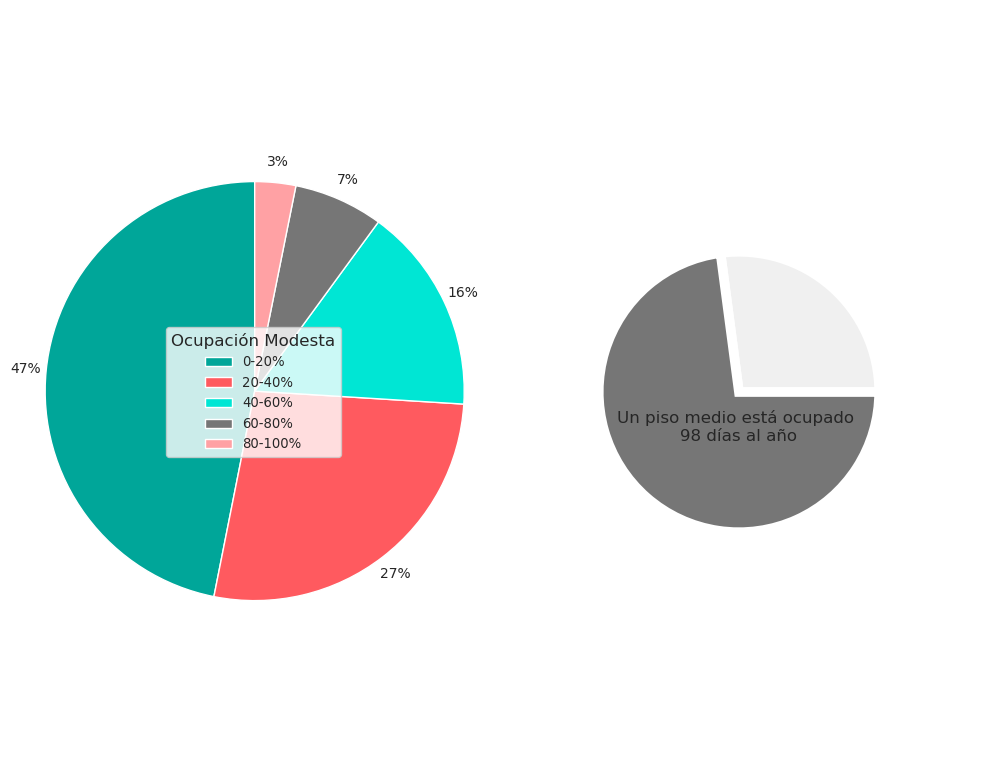

In [32]:
bins = np.array(np.linspace(0,100,6))
labels = ["0-20%","20-40%","40-60%","60-80%","80-100%"]
groups = pd.cut(df_esti1["modest_occupacy"], bins, labels)

fig, (ax1, ax2) = plt.subplots(1,2, figsize = (10,8))
import matplotlib as mpl
mpl.rcParams['font.size'] = 12.0

patches, texts, autotexts = ax1.pie(groups.value_counts().values, startangle = 90, autopct='%1.0f%%', pctdistance=1.1, labeldistance=1.7, 
                                    colors = ['#00A699', '#FF5A5F', "#00e6d4", "#767676", "#ffa1a4"], textprops={'size': 'smaller'})
ax1.legend(patches, labels, fontsize = 9.5, title = "Ocupación Modesta",
           title_fontsize = "medium", loc = 10)
ax1.axis('equal')

ax2.pie((df_esti1["modest_occupacy"].mean()/100*365/365,(365- df_esti1["modest_occupacy"].mean()/100*365)/365), colors=["#f0f0f0", "#767676"],
        startangle = 360, radius = 0.75, pctdistance=0.6,
        wedgeprops={'linewidth':7, 'edgecolor':'white'}, textprops={'size': 'small'})
ax2.text(-0.65,-0.26,"Un piso medio está ocupado \n            {} días al año".format(int(df_esti1["modest_occupacy"].mean()/100*365)))


plt.tight_layout()

plt.show()
#fig.savefig("/home/ignareyesa/Escritorio/TFG/Latex/Images/ocupamodestapie.png")

#### 2.4.2. Estimación optimista

In [33]:
estancia_media = 4.2
estimacion_optimista = 0.5
dias_mes = 30.5

In [34]:
df_esti2["optimist_occupacy"] = estancia_media * df["reviews_per_month"] / (estimacion_optimista * dias_mes)


df_esti2 = df_esti2[df_esti2["optimist_occupacy"] < 1.8]
## Normalizamos los datos
df_esti2["optimist_occupacy"] = (df_esti2["optimist_occupacy"]-df_esti2["optimist_occupacy"].min())/(df_esti2["optimist_occupacy"].max()-df_esti2["optimist_occupacy"].min())*100
df_esti2.head(2)

,listing_id,reviews_per_month,price,cleaning_fee,neighbourhood,latitude,longitude,property_type,room_type,accommodates,...,availability_365,availability_30,availability_90,host_acceptance_rate,review_scores_rating,host_response_time,instant_bookable,amenities,is_location_exact,optimist_occupacy
0,6369,0.607490,70.0,5.0,Chamartín,40.45724,-3.67688,Apartment,Private room,2,...,77,17,77,70.0,98.0,within a few hours,False,"{Wifi,""Air conditioning"",Kitchen,Elevator,Heat...",True,8.723329
1,21853,0.720524,17.0,0.0,Latina,40.40341,-3.74084,Apartment,Private room,1,...,200,0,0,NaN,92.0,NaN,False,"{TV,Internet,Wifi,""Air conditioning"",Kitchen,""...",False,10.464232


In [35]:
df_esti2.shape

(15687, 26)

In [36]:
df_esti2["optimist_occupacy"].describe()

count    15687.000000
mean        32.359552
std         25.773454
min          0.000000
25%          9.151976
50%         27.281463
75%         50.100438
max        100.000000
Name: optimist_occupacy, dtype: float64

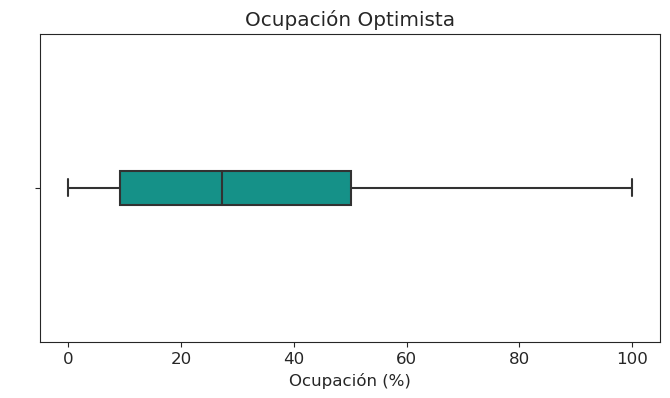

In [37]:
fig, ax = plt.subplots()
fig.set_size_inches(8, 4)
#sns.boxplot(data = df["modest_occupacy"])
sns.boxplot(data = df_esti2, x ="optimist_occupacy", orient="h", width=0.11, fliersize = 2, palette = ['#00A699'])
ax.set_title("Ocupación Optimista")
plt.ylabel(" ")
plt.xlabel("Ocupación (%)")
plt.show()

fig.savefig("/home/ignareyesa/Escritorio/TFG/Latex/Images/ocupaoptimista.png")

In [38]:
x_max = np.percentile(df_esti2["optimist_occupacy"], 75) + 1.5 * (np.percentile(df_esti2["optimist_occupacy"], 75)- np.percentile(df_esti2["optimist_occupacy"], 25))
occupacy_outliers = df_esti2[df_esti2["optimist_occupacy"] > x_max].shape


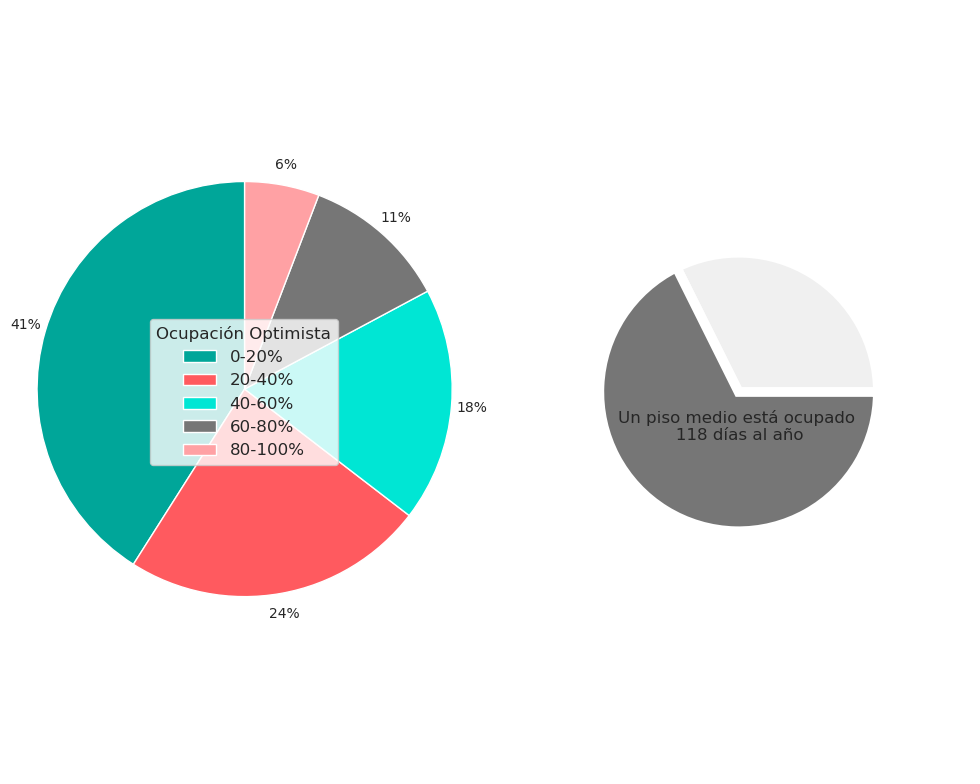

In [39]:
bins = np.array(np.linspace(0,100,6))
labels = ["0-20%","20-40%","40-60%","60-80%","80-100%"]
groups = pd.cut(df_esti2["optimist_occupacy"], bins, labels)

fig, (ax1, ax2) = plt.subplots(1,2, figsize = (10,8))
import matplotlib as mpl
mpl.rcParams['font.size'] = 12.0

patches, texts, autotexts = ax1.pie(groups.value_counts().values, startangle = 90, autopct='%1.0f%%', pctdistance=1.1, labeldistance=1.7, 
                                    colors = ['#00A699', '#FF5A5F', "#00e6d4", "#767676", "#ffa1a4"], textprops={'size': 'smaller'})
ax1.legend(patches, labels, loc = 10, title = "Ocupación Optimista", title_fontsize = "medium")
ax1.axis('equal')

ax2.pie((df_esti2["optimist_occupacy"].mean()/100*365/365,(365- df_esti2["optimist_occupacy"].mean()/100*365)/365), colors=["#f0f0f0", "#767676"],
        startangle = 360, radius = 0.75, pctdistance=0.6,
        wedgeprops={'linewidth':7, 'edgecolor':'white'}, textprops={'size': 'small'})
ax2.text(-0.65,-0.26,"Un piso medio está ocupado \n           {} días al año".format(int(df_esti2["optimist_occupacy"].mean()/100*365)))


plt.tight_layout()

plt.show()
#fig.savefig("/home/ignareyesa/Escritorio/TFG/Latex/Images/ocupaoptimistapie.png")

In [40]:
occupacy = df_esti1[["listing_id", "modest_occupacy"]].merge(df_esti2[["listing_id", "optimist_occupacy"]], right_on = "listing_id", left_on = "listing_id")
df = df.merge(occupacy, right_on="listing_id", left_on = "listing_id")

In [41]:
df.head(2)

,listing_id,reviews_per_month,price,cleaning_fee,neighbourhood,latitude,longitude,property_type,room_type,accommodates,...,availability_30,availability_90,host_acceptance_rate,review_scores_rating,host_response_time,instant_bookable,amenities,is_location_exact,modest_occupacy,optimist_occupacy
0,6369,0.607490,70.0,5.0,Chamartín,40.45724,-3.67688,Apartment,Private room,2,...,17,77,70.0,98.0,within a few hours,False,"{Wifi,""Air conditioning"",Kitchen,Elevator,Heat...",True,6.597713,8.723329
1,21853,0.720524,17.0,0.0,Latina,40.40341,-3.74084,Apartment,Private room,1,...,0,0,NaN,92.0,NaN,False,"{TV,Internet,Wifi,""Air conditioning"",Kitchen,""...",False,7.914410,10.464232


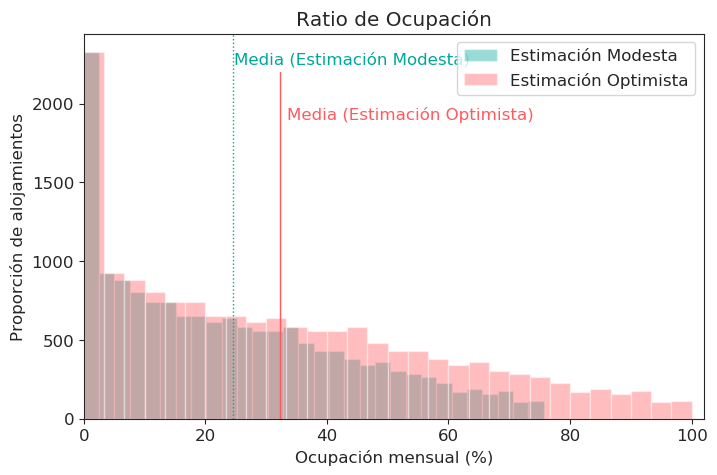

In [42]:
plt.figure(figsize=(8,5))

sns.distplot(df['modest_occupacy'], bins=30, kde = False, color='#00A699')
sns.distplot(df['optimist_occupacy'],bins=30, kde = False, color='#FF5A5F')

plt.title('Ratio de Ocupación')
plt.legend(['Estimación Modesta', 'Estimación Optimista'])
plt.xlabel('Ocupación mensual (%)')
plt.ylabel('Proporción de alojamientos')



plt.axvline(x=df["modest_occupacy"].mean(), ymin=0, ymax=1, linewidth=1, linestyle=':', color='#00A699')
plt.text(df["modest_occupacy"].mean() + 0.3, 2250 , 'Media (Estimación Modesta)', color='#00A699')
# draw and label a line with median value of optimistic estimate
plt.axvline(x=df["optimist_occupacy"].mean(), ymin=0, ymax=0.9, linewidth=1, linestyle='-', color='#FF5A5F')
plt.text(df["optimist_occupacy"].mean()+1, 1900, 'Media (Estimación Optimista)', color='#FF5A5F')
plt.xlim(0,102);

plt.savefig("/home/ignareyesa/Escritorio/TFG/Latex/Images/ratioocupacion1.png")

### 2.5. Estimación de los Ingresos 

#### 2.5.1. Estimación Modesta

In [43]:
df["modest_income"] = (df["price"]) * 30.5/100 * df["modest_occupacy"] * 12  
df["modest_income"].describe()

count    15687.000000
mean      6500.165443
std       7480.907366
min          0.000000
25%       1389.582820
50%       4141.324385
75%       9077.721686
max      81154.372415
Name: modest_income, dtype: float64

#### 2.5.2. Estimación Optimista

In [44]:
df["optimist_income"] = (df["price"]) * 30.5/100 * df["optimist_occupacy"] * 12 
df["optimist_income"].describe()

count     15687.000000
mean       8594.353408
std        9891.065432
min           0.000000
25%        1837.271058
50%        5475.553762
75%       12002.332708
max      107300.246927
Name: optimist_income, dtype: float64

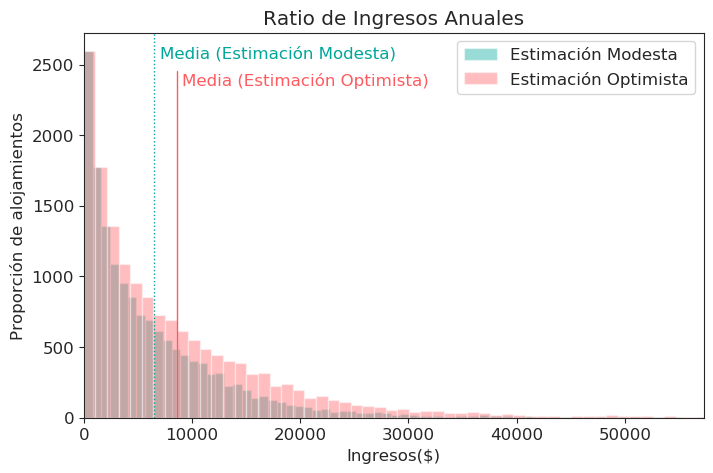

In [45]:
plt.figure(figsize=(8,5))

sns.distplot(df['modest_income'], kde=False, bins=100, color='#00A699')
sns.distplot(df['optimist_income'], kde=False, bins=100, color='#FF5A5F')

plt.title('Ratio de Ingresos Anuales')
plt.legend(['Estimación Modesta', 'Estimación Optimista'])
plt.xlabel('Ingresos($)')
plt.xlim((0,df["optimist_income"].max()-50000))
plt.ylabel('Proporción de alojamientos')


plt.axvline(df['modest_income'].mean(), ymin=0, ymax=1, linewidth=1, linestyle=':', color='#00A699')
plt.text(df['modest_income'].mean()+500, 2550, 'Media (Estimación Modesta)', color='#00A699')


plt.axvline(df['optimist_income'].mean(), ymin=0, ymax=0.9, linewidth=1, linestyle='-', color='#FF5A5F')
plt.text(df['optimist_income'].mean()+500, 2350, 'Media (Estimación Optimista)', color='#FF5A5F');

plt.savefig("/home/ignareyesa/Escritorio/TFG/Latex/Images/ratioingresos.png")

## 3. Análisis Exploratorio

Buscamos la relación entre la ocupación y los ingresos en función del resto de variables

### 3.1. Mapa de correlación

In [46]:
### Convertimos las variables categóricas a numéricas

In [47]:
df["neighbourhood"] = df["neighbourhood"].astype("category")
df["cat_neighbourhood"] = df["neighbourhood"].cat.codes

df["host_is_superhost"] = df["host_is_superhost"].astype("category")
df["cat_host_is_superhost"] = df["host_is_superhost"].cat.codes
df["superhost"] = "Super Host"
df.loc[df["cat_host_is_superhost"] == 0, "superhost"] = "Normal Host"

df["room_type"] = df["room_type"].astype("category")
df["cat_room_type"] = df["room_type"].cat.codes

df["instant_bookable"] = df["instant_bookable"].astype("category")
df["cat_instant_bookable"] = df["instant_bookable"].cat.codes

df["property_type"] = df["property_type"].astype("category")
df["cat_property_type"] = df["property_type"].cat.codes

df["cancellation_policy"] = df["cancellation_policy"].astype("category")
df["cat_cancellation_policy"] = df["cancellation_policy"].cat.codes

df["host_response_time"] = df["host_response_time"].astype("category")
df["cat_host_response_time"] = df["host_response_time"].cat.codes

##########   OTRA MANERA DE HACERLO    ##############

#  from sklearn.preprocessing import LabelEncoder

#  lb_make = LabelEncoder()
#  df["neighbourhood_code"] = lb_make.fit_transform(df["neighbourhood"])
#  df[["neighbourhood", "neighbourhood_code"]].head()

In [48]:
df.head(3)

,listing_id,reviews_per_month,price,cleaning_fee,neighbourhood,latitude,longitude,property_type,room_type,accommodates,...,modest_income,optimist_income,cat_neighbourhood,cat_host_is_superhost,superhost,cat_room_type,cat_instant_bookable,cat_property_type,cat_cancellation_policy,cat_host_response_time
0,6369,0.607490,70.0,5.0,Chamartín,40.45724,-3.67688,Apartment,Private room,2,...,1690.334198,2234.916880,4,1,Super Host,2,0,1,0,2
1,21853,0.720524,17.0,0.0,Latina,40.40341,-3.74084,Apartment,Private room,1,...,492.434601,651.084504,9,0,Normal Host,2,0,1,2,-1
2,24805,0.145083,89.0,30.0,Centro,40.42202,-3.70395,Apartment,Entire home/apt,3,...,394.572521,521.693751,3,0,Normal Host,0,1,1,1,2


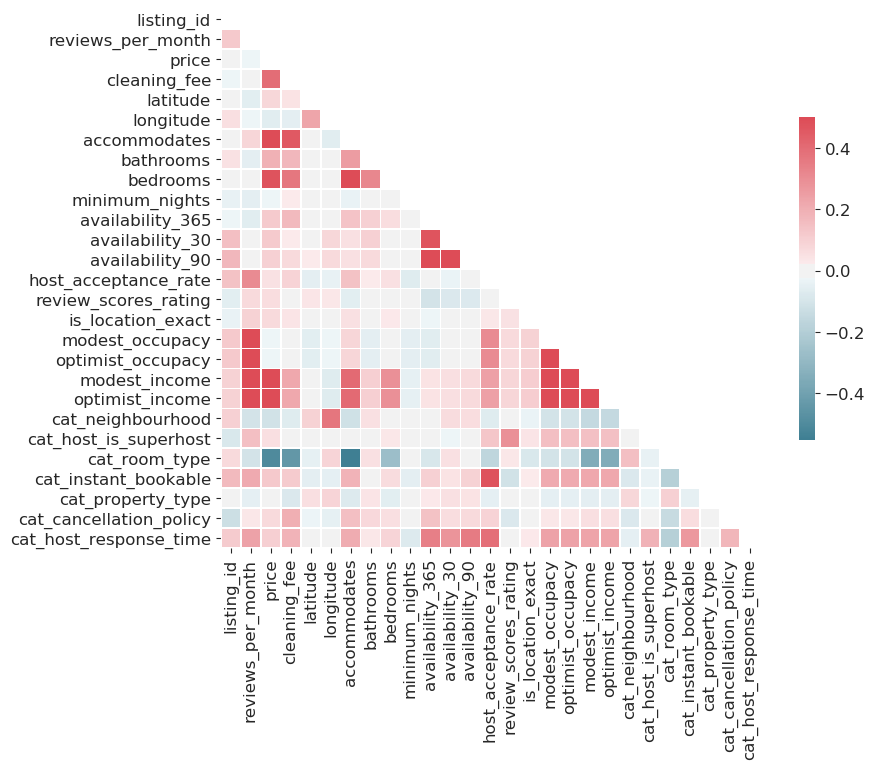

In [49]:
corr = df.corr()

# Generamos una mascara para obtener solo un triángulo
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True


fig, ax = plt.subplots(figsize=(10, 7))

# Generamos una paleta de colores para el mapa de correlación
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Ajuste del mapa
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.5, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink":.6});

plt.savefig("/home/ignareyesa/Escritorio/TFG/Latex/Images/mapacorrelacion.png")

Se puede obsevar que `income` crece con `nº reviews por mes`, `precio`, `tasa de limpieza`, `accomodates` y `cat_host_is_superhost` y decrece con `cat_neighbourhood` y `cat_room_type`.

De igual forma, `occupancy` crece con `nº reviews por mes`, `accomodates` y `cat_host_is_superhost` y decrece con `cat_neighbourhood`, `cat_room_type` y `precio`.

Con estas resultados vamos a estudiar diferentes relaciones.

#### BARRIO

In [50]:
df.neighbourhood.isnull().sum()

0

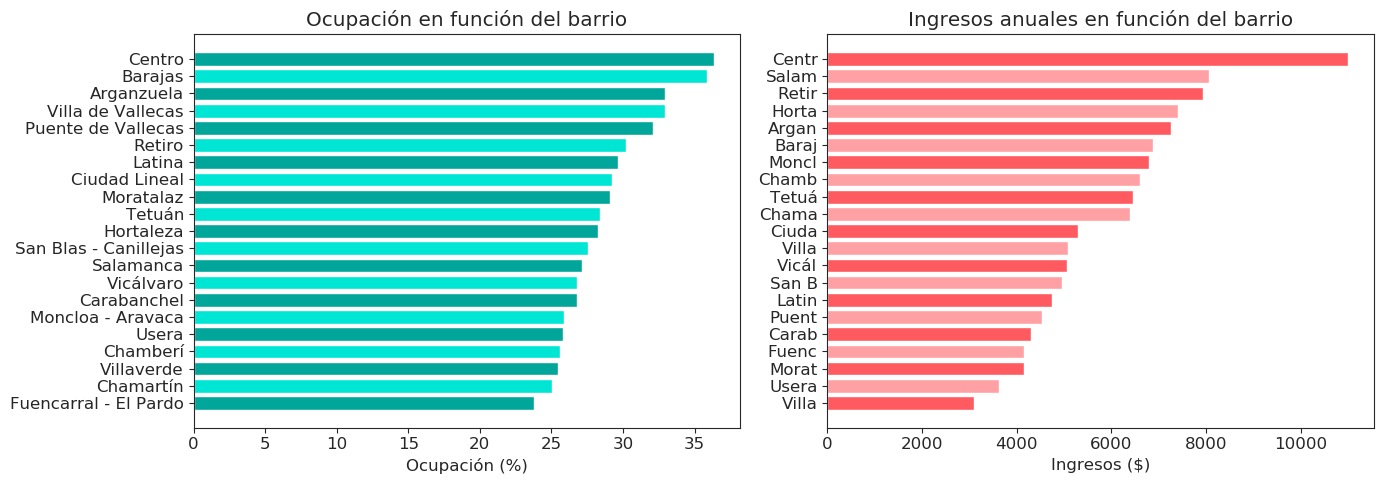

In [51]:
df_barrio = df[["optimist_income", "optimist_occupacy", "neighbourhood"]].groupby("neighbourhood").mean()
fig, (ax1,ax2) = plt.subplots(1,2, figsize = (14,5))
ax2.barh(df_barrio.sort_values("optimist_income").index, df_barrio.sort_values("optimist_income")["optimist_income"], color = ['#FF5A5F', "#ffa1a4"])
ax1.barh(df_barrio.sort_values("optimist_occupacy").index, df_barrio.sort_values("optimist_occupacy")["optimist_occupacy"], color = ['#00A699', "#00e6d4"])
plt.yticks(df_barrio.sort_values("optimist_occupacy").index, df_barrio.sort_values("optimist_occupacy").index.str[:5])
ax1.set(xlabel = "Ocupación (%)", title="Ocupación en función del barrio")
ax2.set( xlabel = "Ingresos ($)", title="Ingresos anuales en función del barrio")
plt.tight_layout()

fig.savefig("/home/ignareyesa/Escritorio/TFG/Latex/Images/corrbarrio.png")

#### SUPERHOST

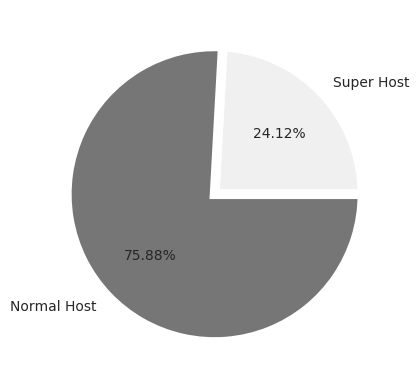

In [52]:
df.host_is_superhost.isna().sum()
df.host_is_superhost.fillna(value=False, inplace=True)

super_host    = df.host_is_superhost.value_counts()[True]
no_super_host = len(df.host_is_superhost) - df.host_is_superhost.value_counts()[True]
names = ['Super Host','Normal Host']
size  = [super_host, no_super_host]

plt.pie(size, labels=names, colors=["#f0f0f0", "#767676"], 
        autopct='%.2f%%', pctdistance=0.6,
        wedgeprops={'linewidth':7, 'edgecolor':'white'}, textprops={'size': 'small'})


fig = plt.gcf()
plt.show()

fig.savefig("/home/ignareyesa/Escritorio/TFG/Latex/Images/superhostpie.png")

In [53]:
df_host = df[["host_is_superhost", "optimist_income", "optimist_occupacy"]].groupby("host_is_superhost").mean().sort_values("optimist_income", ascending=False)

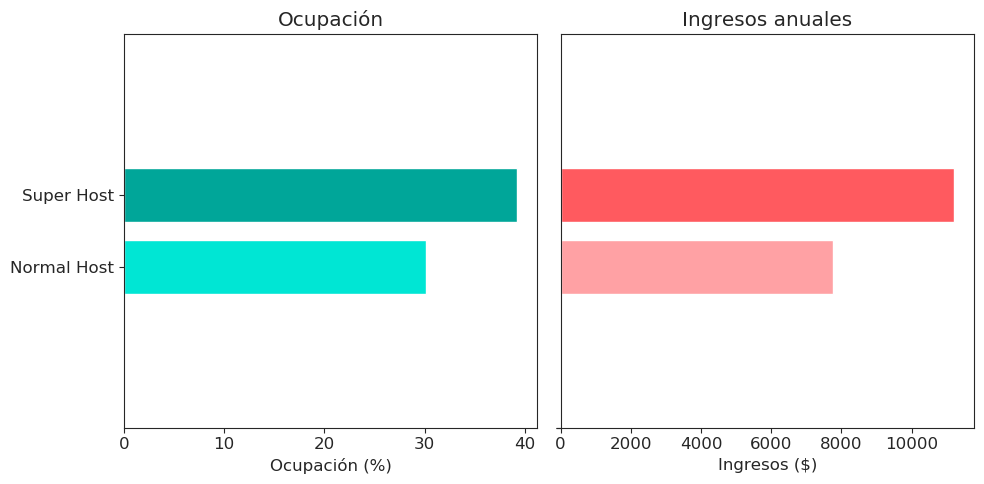

In [54]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (10,5))

ax2.barh((0.6,0.4), df_host.optimist_income, height=0.15, color=['#FF5A5F', "#ffa1a4"])
ax2.set_yticks((-0.05,-0.05))
ax2.set_yticklabels( (""))
ax2.set_ylim(-0.05,1.05)
ax2.set(title = "Ingresos anuales")
ax1.barh((0.6,0.4), df_host.optimist_occupacy, height=0.15, color=['#00A699', "#00e6d4"])
ax1.set_yticks((0.6,0.4))
ax1.set_yticklabels( ("Super Host", "Normal Host"))
ax1.set_ylim(-0.05,1.05)
ax1.set(xlabel = "Ocupación (%)")
ax2.set(xlabel = "Ingresos ($)")
ax1.set(title = "Ocupación")

plt.tight_layout()

fig.savefig("/home/ignareyesa/Escritorio/TFG/Latex/Images/hosttipoocuing.png")

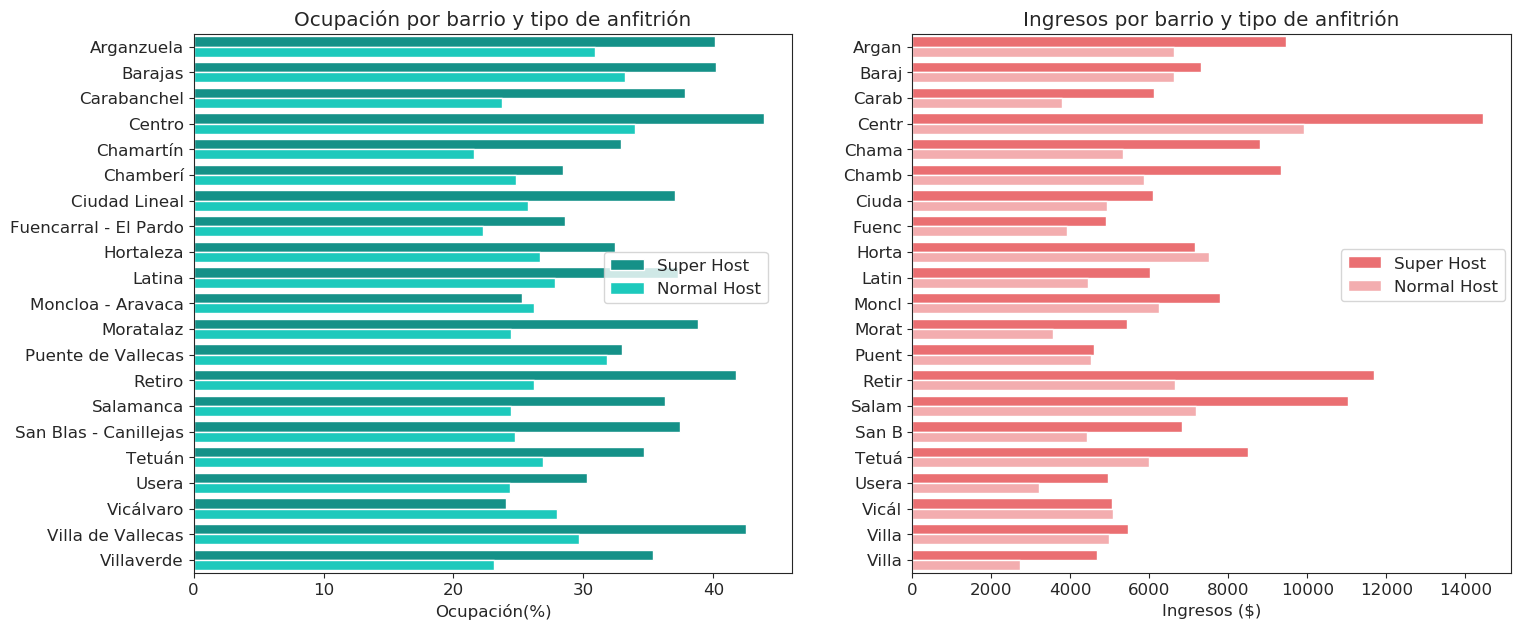

In [55]:
# Agrupamos en función del tipo de host y barrio
df_grouped = pd.DataFrame(df.groupby(['neighbourhood', 'host_is_superhost'])['optimist_occupacy'].agg(np.mean))
df_grouped.sort_values(by='optimist_occupacy', ascending=False, inplace=True)
df_grouped.reset_index(inplace=True)


fig, (ax1, ax2) = plt.subplots(1,2, figsize=(17, 7))
sns.barplot(x='optimist_occupacy', y='neighbourhood', hue='host_is_superhost', hue_order=[True, False], 
            data=df_grouped, palette = ['#00A699', "#00e6d4"], ax = ax1)


ax1.set_title('Ocupación por barrio y tipo de anfitrión')
ax1.set(ylabel ="", xlabel='Ocupación(%)')


handles, labels = ax1.get_legend_handles_labels()
ax1.legend((handles), ('Super Host', 'Normal Host'), bbox_to_anchor=(0.685, 0.5), borderaxespad=0.);


df_grouped = pd.DataFrame(df.groupby(['neighbourhood', 'host_is_superhost'])['optimist_income'].agg(np.mean))
df_grouped.sort_values(by='optimist_income', ascending=False, inplace=True)
df_grouped.reset_index(inplace=True)

sns.barplot(x='optimist_income', y='neighbourhood', hue='host_is_superhost', hue_order=[True, False], 
            data=df_grouped, palette=['#FF5A5F', "#ffa1a4"], ax = ax2)


ax2.set_title('Ingresos por barrio y tipo de anfitrión')
ax2.set(xlabel='Ingresos ($)', ylabel =None)
ax2.set_yticklabels(pd.Series(sorted(df_grouped["neighbourhood"].unique())).str[:5].values)


handles, labels = ax2.get_legend_handles_labels()
ax2.legend((handles), ('Super Host', 'Normal Host'), bbox_to_anchor=(0.99, 0.6), borderaxespad=0.);

fig.savefig("/home/ignareyesa/Escritorio/TFG/Latex/Images/corrbarriohost.png")

In [56]:
def correlations_bar1(df, x1, y, xlabel, title):

    df_corr = df[[y, x1]].groupby(y).mean().sort_values(x1, ascending=True)

    fig, (ax1) = plt.subplots(figsize = (9,4))

    ax1.barh(np.arange(len(df_corr)), df_corr[x1], height=0.35, color=['#00A699', "#00e6d4"])
    ax1.set_yticks(np.arange(len(df_corr)))
    ax1.set_yticklabels( (df_corr.index))
    ax1.set(xlabel = xlabel)
    ax1.set(title = title)

    plt.tight_layout();

def correlations_bar2(df, x1, x2, y):

    df_corr = df[[y, x1, x2]].groupby(y).mean().sort_values(x1, ascending=True)

    fig, (ax1, ax2) = plt.subplots(1,2, figsize = (14,4))

    ax1.barh(np.arange(len(df_corr)), df_corr[x1], height=0.35, color=['#00A699', "#00e6d4"])
    ax1.set_yticks(np.arange(len(df_corr)))
    ax1.set_yticklabels( (df_corr.index))
    ax1.set(xlabel = "Ocupación (%)")
    ax1.set(title = "Ocupación")

    ax2.barh(np.arange(len(df_corr)), df_corr[x2], height=0.35, color=['#FF5A5F', "#ffa1a4"])
    ax2.set_yticks((-0.05,-0.05))
    ax2.set_yticklabels( (""))
    ax2.set(title = "Ingresos anuales")
    ax2.set(xlabel = "Ingresos ($)")

    plt.tight_layout();

#### POLITICA DE CANCELACION

In [57]:
df["cancellation_policy_es"] = pd.Series()
df.loc[df["cancellation_policy"]=="flexible", "cancellation_policy_es"] = "Flexible"
df.loc[df["cancellation_policy"]=="moderate", "cancellation_policy_es"] = "Moderada"
df.loc[df["cancellation_policy"]=="strict_14_with_grace_period", "cancellation_policy_es"] = "Estricta"
df.loc[df["cancellation_policy"]=="super_strict_30", "cancellation_policy_es"] = "Súper Estricta 30 días"
df.loc[df["cancellation_policy"]=="super_strict_60", "cancellation_policy_es"] = "Súper Estricta 60 días"

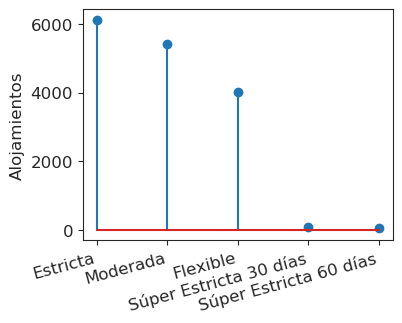

In [58]:
plt.subplots(figsize = (4,3))
plt.stem(df["cancellation_policy_es"].value_counts())
plt.xticks(np.arange(5), df["cancellation_policy_es"].value_counts().index, rotation = 15, ha = "right")
plt.ylabel("Alojamientos");

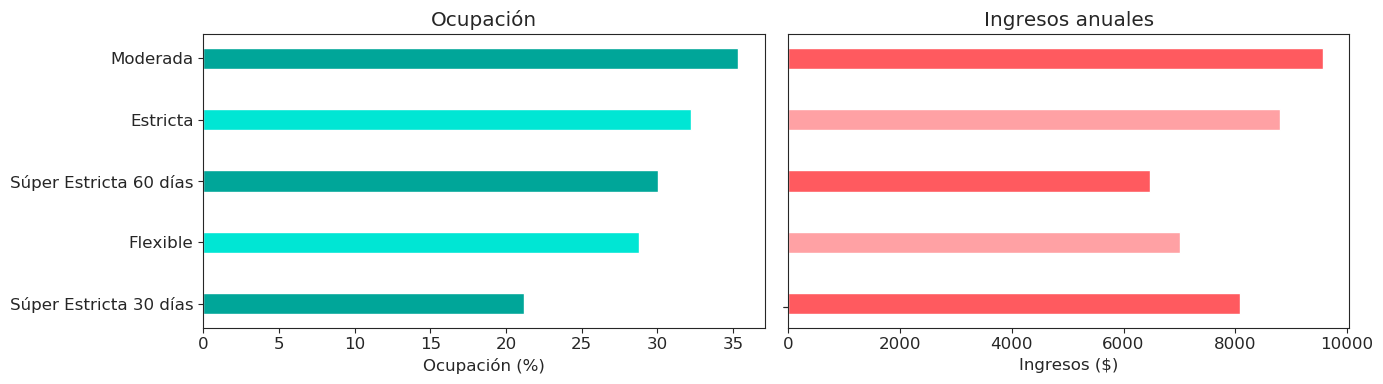

In [59]:
correlations_bar2(df, x1 = "optimist_occupacy", x2 = "optimist_income", y = "cancellation_policy_es")
plt.savefig("/home/ignareyesa/Escritorio/TFG/Latex/Images/corrcancelacion.png")

In [60]:
bins = np.array(np.linspace(0,100,6))
labels = ["0-20%","20-40%","40-60%","60-80%","80-100%"]
df["groups_review_scores_rating"] = pd.cut(df["review_scores_rating"], bins, labels)

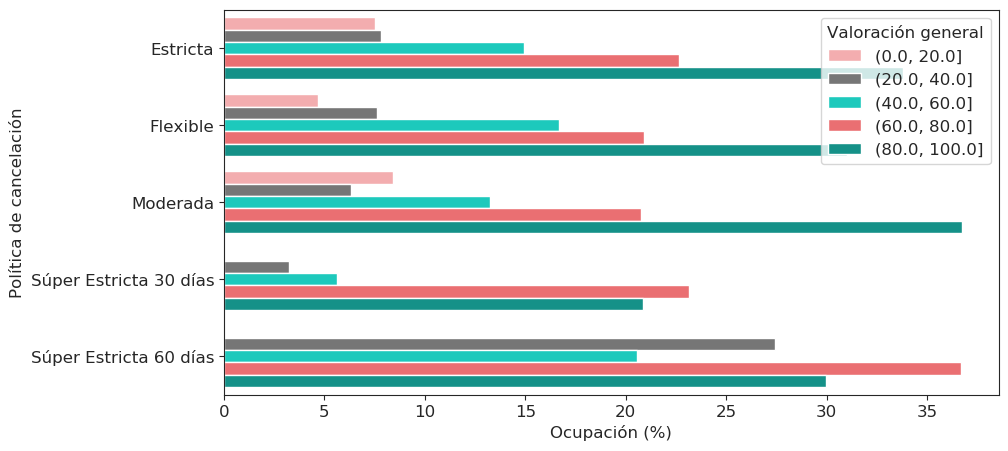

In [61]:
# Agrupamos en función de la politica de cancelacion y nota
df_grouped = pd.DataFrame(df.groupby(["cancellation_policy_es", "groups_review_scores_rating"])['optimist_occupacy'].agg(np.mean))
df_grouped.reset_index(inplace=True)



fig, ax1 = plt.subplots(figsize=(10, 5))
sns.barplot(x='optimist_occupacy',hue="groups_review_scores_rating", y="cancellation_policy_es", 
            data=df_grouped, ax = ax1, palette = [ "#ffa1a4", "#767676", "#00e6d4",'#FF5A5F',  '#00A699'])
ax1.set(xlabel = "Ocupación (%)", ylabel = "Política de cancelación")
ax1.legend(title = "Valoración general")
plt.savefig("/home/ignareyesa/Escritorio/TFG/Latex/Images/corrcancelacionvaloracion.png");

In [62]:
bins = np.array(np.linspace(0,100,6))
labels = ["0-20%","20-40%","40-60%","60-80%","80-100%"]
df["groups_host_acceptance_rate"] = pd.cut(df["host_acceptance_rate"], bins, labels)

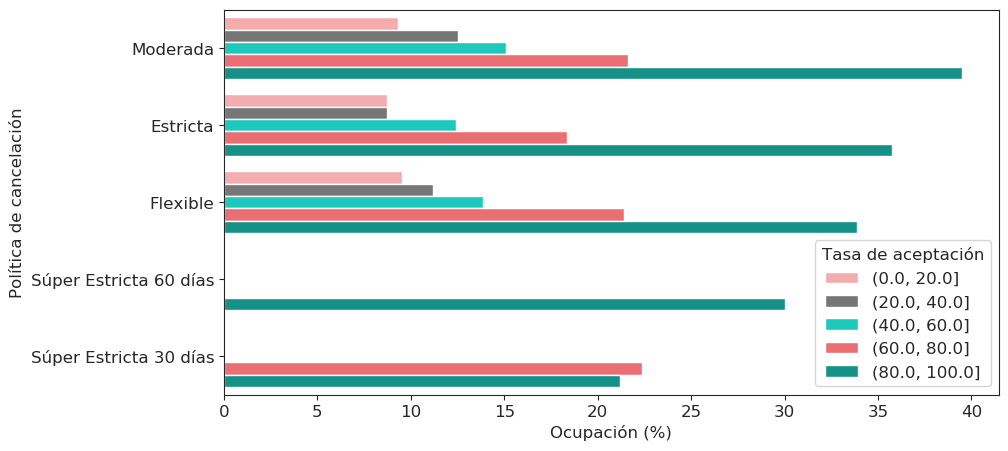

In [63]:
# Agrupamos en función del tipo de cancelación y tasa de aceptación
df_grouped = pd.DataFrame(df.groupby(["cancellation_policy_es", "groups_host_acceptance_rate"])['optimist_occupacy'].agg(np.mean))
df_grouped.sort_values(by='optimist_occupacy', ascending=False, inplace=True)
df_grouped.reset_index(inplace=True)



fig, ax1 = plt.subplots(figsize=(10, 5))
sns.barplot(x='optimist_occupacy',hue="groups_host_acceptance_rate", y="cancellation_policy_es",
            data=df_grouped, ax = ax1, palette = [ "#ffa1a4", "#767676", "#00e6d4",'#FF5A5F',  '#00A699'])
ax1.set(xlabel = "Ocupación (%)", ylabel = "Política de cancelación")
ax1.legend(title = "Tasa de aceptación", loc = 4);
plt.savefig("/home/ignareyesa/Escritorio/TFG/Latex/Images/corrcancelacionaceptacion.png");

#### TIEMPO DE RESPUESTA

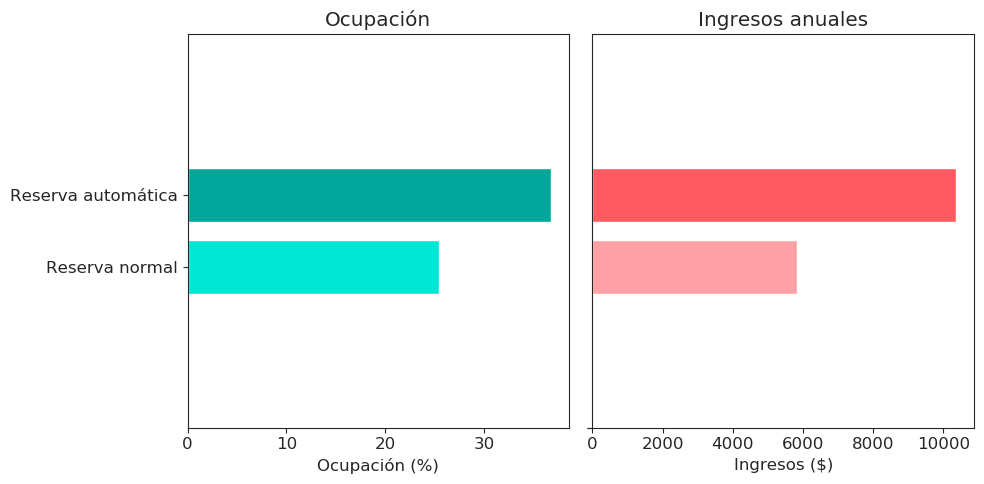

In [64]:
df_instant = df[["instant_bookable", "optimist_income", "optimist_occupacy"]].groupby("instant_bookable").mean().sort_values("optimist_income", ascending=False)

fig, (ax1, ax2) = plt.subplots(1,2, figsize = (10,5))

ax2.barh((0.6,0.4), df_instant.optimist_income, height=0.15, color=['#FF5A5F', "#ffa1a4"])
ax2.set_yticks((-0.05,-0.05))
ax2.set_yticklabels( (""))
ax2.set_ylim(-0.05,1.05)
ax2.set(title = "Ingresos anuales")
ax1.barh((0.6,0.4), df_instant.optimist_occupacy, height=0.15, color=['#00A699', "#00e6d4"])
ax1.set_yticks((0.6,0.4))
ax1.set_yticklabels( ("Reserva automática", "Reserva normal"))
ax1.set_ylim(-0.05,1.05)
ax1.set(xlabel = "Ocupación (%)")
ax2.set(xlabel = "Ingresos ($)")
ax1.set(title = "Ocupación")

plt.tight_layout()

fig.savefig("/home/ignareyesa/Escritorio/TFG/Latex/Images/corrinstanbookable.png")

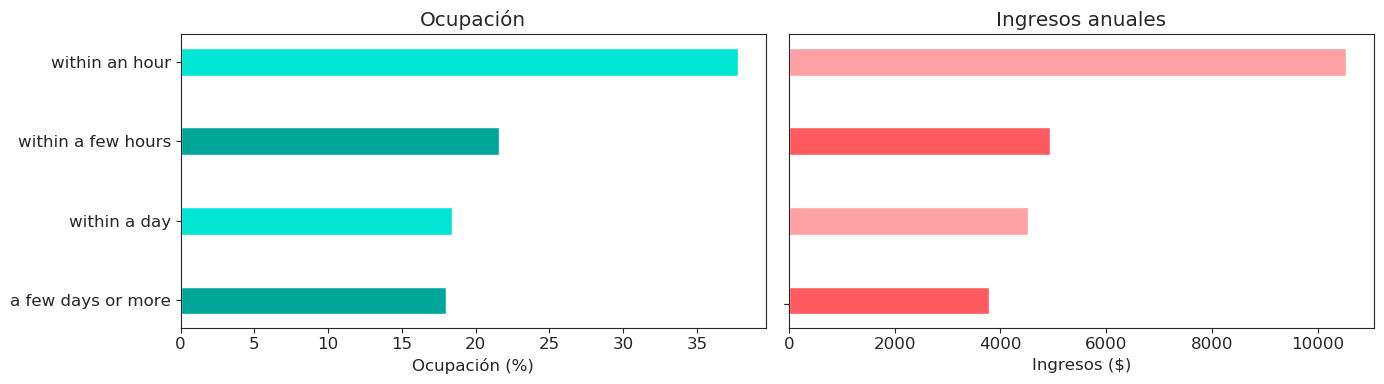

In [65]:
correlations_bar2(df, x1 = "optimist_occupacy", x2 = "optimist_income", y = "host_response_time")
plt.savefig("/home/ignareyesa/Escritorio/TFG/Latex/Images/corrcrespuesta.png")

#### TIPO DE HABITACION

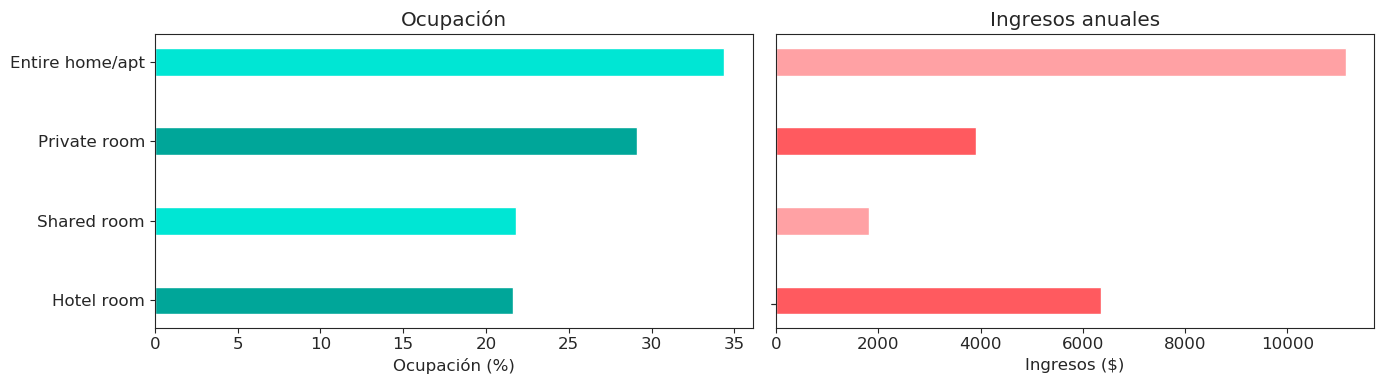

In [66]:
correlations_bar2(df, x1 = "optimist_occupacy", x2 = "optimist_income", y = "room_type")
plt.savefig("/home/ignareyesa/Escritorio/TFG/Latex/Images/corrctipohabita.png")

#### VALORACIÓN GENERAL

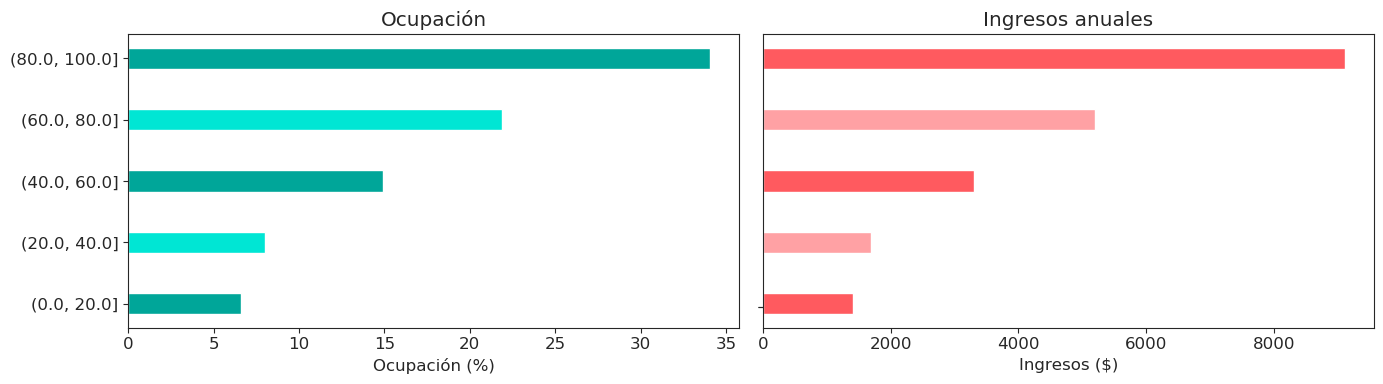

In [67]:
bins = np.array(np.linspace(0,100,6))
labels = ["0-20%","20-40%","40-60%","60-80%","80-100%"]
df["groups_review_scores_rating"] = pd.cut(df["review_scores_rating"], bins, labels)
correlations_bar2(df, x1 = "optimist_occupacy", x2 = "optimist_income", y = "groups_review_scores_rating")
plt.savefig("/home/ignareyesa/Escritorio/TFG/Latex/Images/corrvaloracion.png")

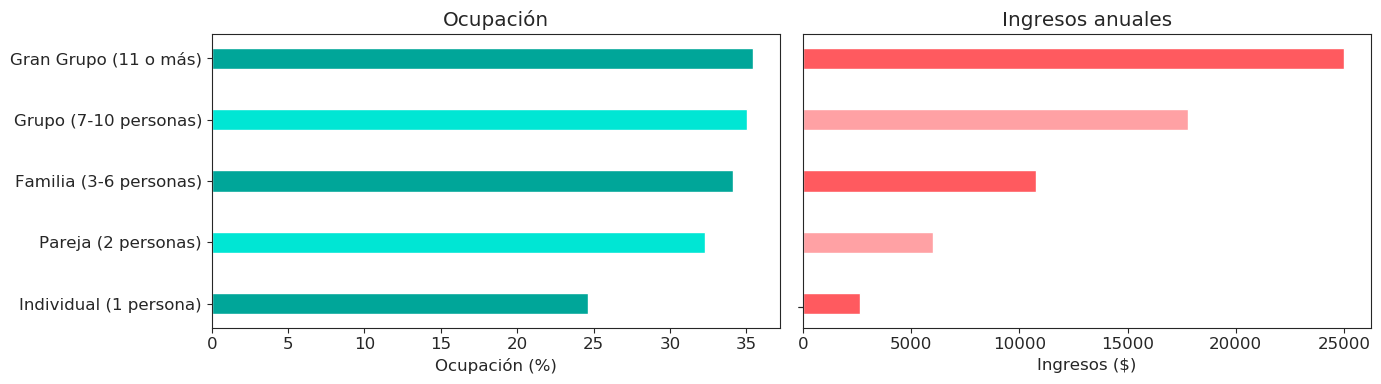

In [68]:
df["groups_accommodates"] = pd.Series()
df.loc[df["accommodates"] == 1, "groups_accommodates"] = "Individual (1 persona)"
df.loc[df["accommodates"] == 2, "groups_accommodates"] = "Pareja (2 personas)"
df.loc[((df["accommodates"] == 3) | (df["accommodates"] == 4) | (df["accommodates"] == 5) | (df["accommodates"] == 6)), "groups_accommodates"] = "Familia (3-6 personas)"
df.loc[((df["accommodates"] >6) & (df["accommodates"] < 11)), "groups_accommodates"] = "Grupo (7-10 personas)"
df.loc[df["accommodates"] >= 11, "groups_accommodates"] = "Gran Grupo (11 o más)"
correlations_bar2(df, x1 = "optimist_occupacy", x2 = "optimist_income", y = "groups_accommodates")
plt.savefig("/home/ignareyesa/Escritorio/TFG/Latex/Images/corrhuespedes.png")

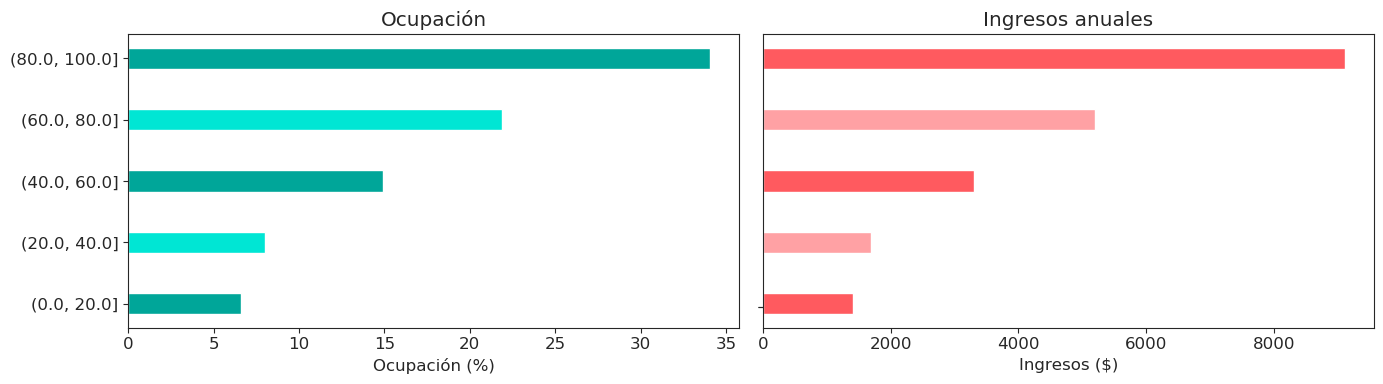

In [69]:
bins = np.array(np.linspace(0,100,6))
labels = ["0-20%","20-40%","40-60%","60-80%","80-100%"]
df["groups_host_acceptance_rate"] = pd.cut(df["host_acceptance_rate"], bins, labels)
correlations_bar2(df, x1 = "optimist_occupacy", x2 = "optimist_income", y = "groups_review_scores_rating")
plt.savefig("/home/ignareyesa/Escritorio/TFG/Latex/Images/corraceptacion.png")

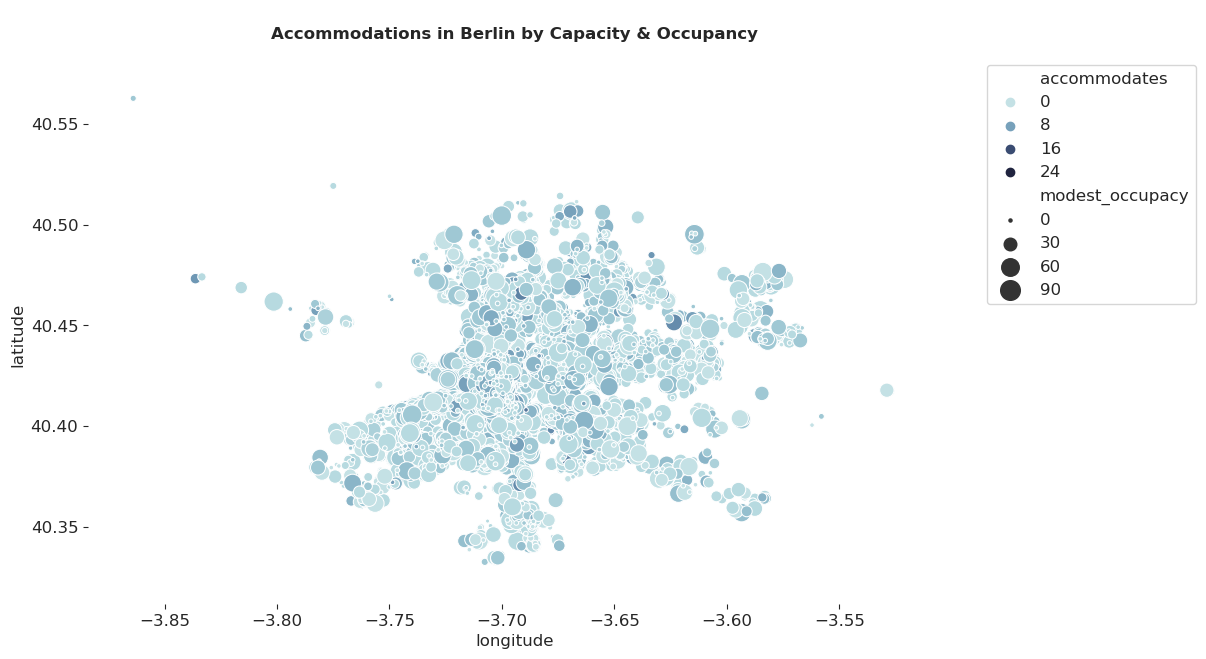

In [70]:

cmap = sns.cubehelix_palette(rot=-.2, as_cmap=True)
fig, ax = plt.subplots(figsize=(11,7))


ax = sns.scatterplot(x="longitude", y="latitude", size='modest_occupacy', sizes=(5, 200),
                     hue='accommodates', palette=cmap,  data=df)
ax.legend(bbox_to_anchor=(1.3, 1), borderaxespad=0.)
plt.title('\nAccommodations in Berlin by Capacity & Occupancy\n', fontsize=12, fontweight='bold')


sns.despine(ax=ax, top=True, right=True, left=True, bottom=True);

#### Anfitriones con más ocupación

In [71]:
top_hosts = df.loc[df["optimist_occupacy"]>80]
low_hosts = df.loc[df["optimist_occupacy"]<15]

In [72]:
top_hosts = top_hosts.merge(df_2, right_on="id", left_on="listing_id")
low_hosts = low_hosts.merge(df_2, right_on="id", left_on="listing_id")

In [73]:
def grouped_bar(column1, column2, df1 = low_hosts, df2 = top_hosts) :
    
    df_izq = pd.DataFrame(df1[column1].value_counts() / df1[column1].value_counts().sum())
    df_drch = pd.DataFrame(df2[column2].value_counts() / df2[column2].value_counts().sum())
    df_f = df_izq.merge(df_drch, right_index=True, left_index=True)
    df_f.columns = ["general", "top"]
    
    width = 0.2
    color = ["#f0f0f0", "#767676"]
    plt.subplots(figsize = (7,5))
    plt.bar(np.arange(len(df_f.index))-width/2, df_f.iloc[:,1], width=width, label = "Buen Anfitrión ", color = color[0])
    plt.bar(np.arange(len(df_f.index))+width/2, df_f.iloc[:,0], width=width, label = "Mal Anfitrión", color = color[1])
    plt.xticks(np.arange(len(df_f.index)), labels = df_f.index, rotation = 7, ha = "right")
    plt.ylabel("Porcentaje de alojamientos")
    plt.legend();

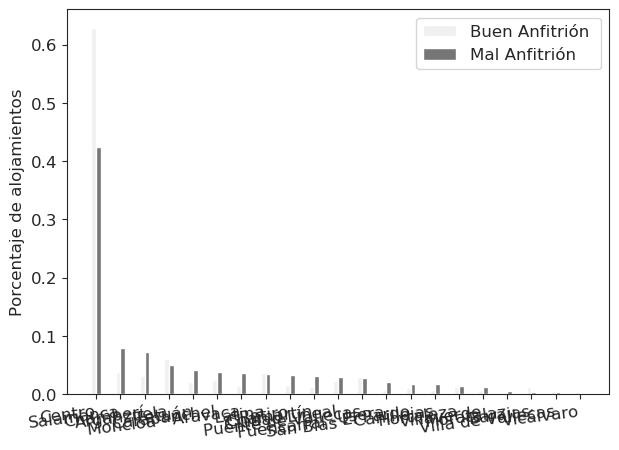

In [74]:
grouped_bar(column1="neighbourhood_x",column2="neighbourhood_x")

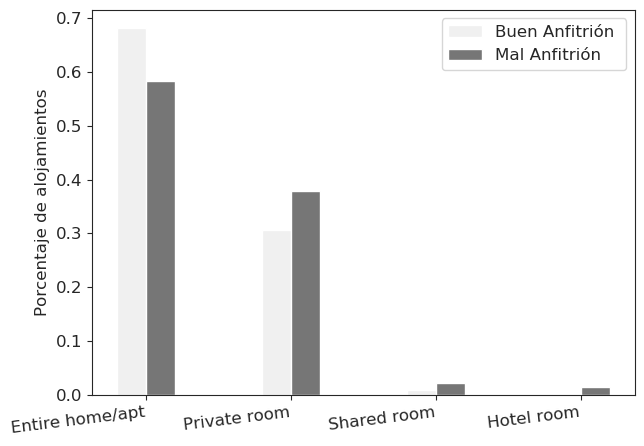

In [75]:
grouped_bar(column1="room_type_x",column2="room_type_x")
plt.savefig("/home/ignareyesa/Escritorio/TFG/Latex/Images/comptipohabitacion.png")

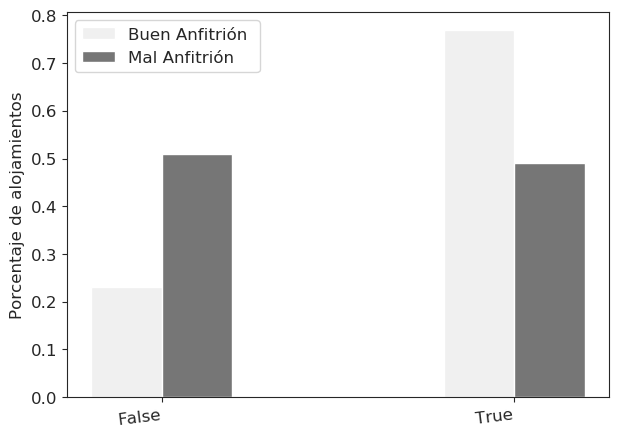

In [76]:
grouped_bar(column1="instant_bookable_x",column2="instant_bookable_x")
plt.savefig("/home/ignareyesa/Escritorio/TFG/Latex/Images/comptiporeserva.png")

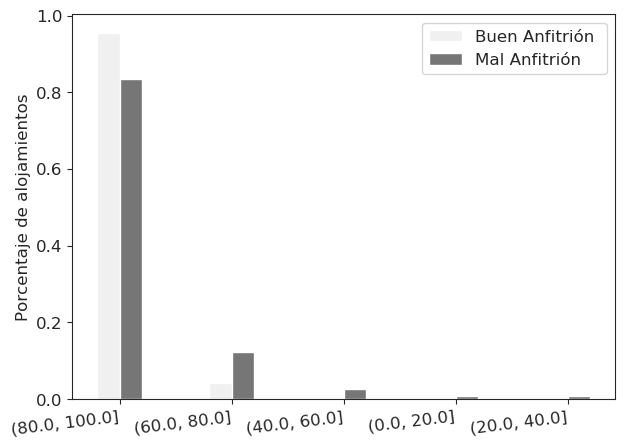

In [77]:
grouped_bar(column1="groups_review_scores_rating",column2="groups_review_scores_rating")
plt.savefig("/home/ignareyesa/Escritorio/TFG/Latex/Images/compvaloracion.png")

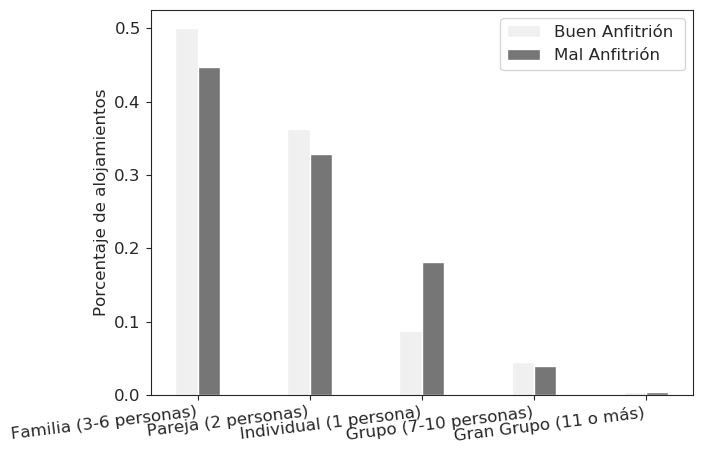

In [78]:
grouped_bar(column1="groups_accommodates",column2="groups_accommodates")
plt.savefig("/home/ignareyesa/Escritorio/TFG/Latex/Images/compcapacidad.png")

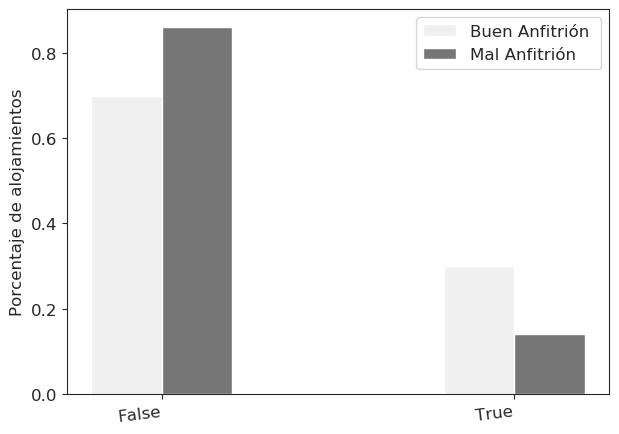

In [79]:
grouped_bar(column1="host_is_superhost_x",column2="host_is_superhost_x")
plt.savefig("/home/ignareyesa/Escritorio/TFG/Latex/Images/compsuperhost.png")

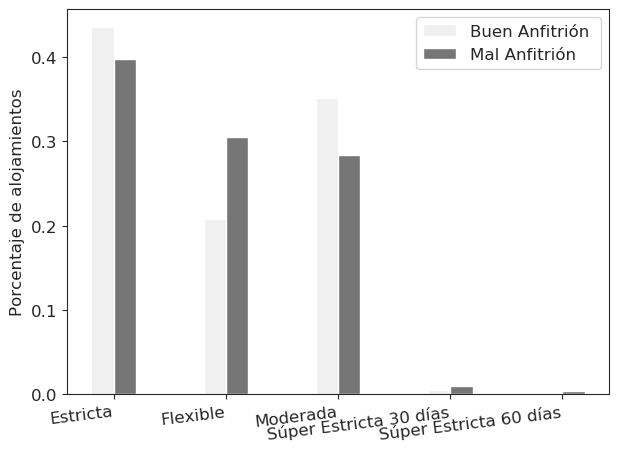

In [80]:
grouped_bar(column1="cancellation_policy_es",column2="cancellation_policy_es")
plt.savefig("/home/ignareyesa/Escritorio/TFG/Latex/Images/comptipocancelacion.png")

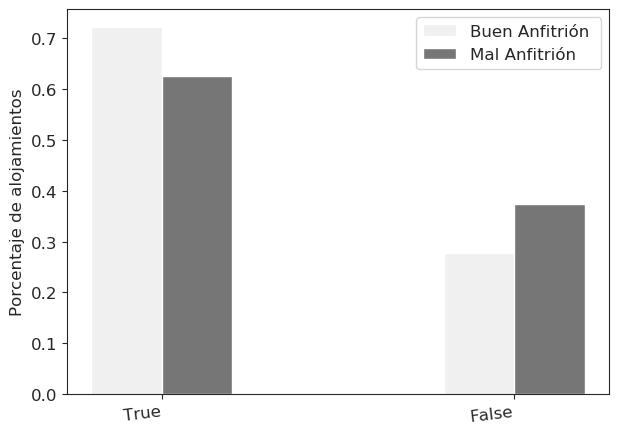

In [81]:
grouped_bar(column1="is_location_exact_x",column2="is_location_exact_x")
plt.savefig("/home/ignareyesa/Escritorio/TFG/Latex/Images/complocexact.png")

### Servicios ofrecidos un mayor número de veces

In [82]:
# Se utiliza la librería nltk
from nltk.corpus import stopwords
stop = stopwords.words('english')



# Se eliminan las stopwords
top_host2 = top_hosts['amenities_x'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

top_host3 = []
for i in top_host2:
    top_host3.append(i.replace(",", " ").replace("{", " ").replace("}", " ").replace('\"', " " ).replace("\'", " "))
    
from collections import Counter
resul = Counter(" ".join(top_host3).split()).most_common(19)
resul = pd.DataFrame(resul).set_index(0)


In [83]:
# Se utiliza la librería nltk

from nltk.corpus import stopwords
stop = stopwords.words('english')



# Se eliminan las stopwords
top_host2 = low_hosts['amenities_x'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

top_host3 = []
for i in top_host2:
    top_host3.append(i.replace(",", " ").replace("{", " ").replace("}", " ").replace('\"', " " ).replace("\'", " "))
    
from collections import Counter
resul2 = Counter(" ".join(top_host3).split()).most_common(19)
resul2 = pd.DataFrame(resul2).set_index(0)


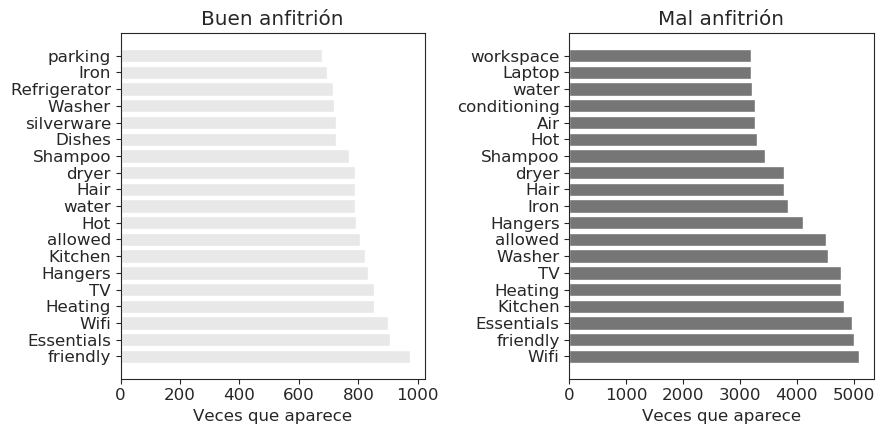

In [84]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize = (9,4.5))
color = ["#e8e8e8", "#767676"]
ax1.barh(resul.index, resul[1], color = color[0])
ax1.set(xlabel = "Veces que aparece", title = "Buen anfitrión")
ax2.barh(resul2.index, resul2[1], color = color[1])
ax2.set(xlabel = "Veces que aparece", title = "Mal anfitrión")
plt.tight_layout()
plt.savefig("/home/ignareyesa/Escritorio/TFG/Latex/Images/compalabras.png")